<a href="https://colab.research.google.com/github/Aishaamalik/Insurance-Claim-Fraud-Detection/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Insurance Claim Fraud Detection**

## **Loading data and  inspecting it**

In [1]:
!pip install openpyxl


In [2]:
import pandas as pd


In [3]:
from google.colab import files
uploaded = files.upload()


Saving Worksheet in Case Study question 2.xlsx to Worksheet in Case Study question 2.xlsx


In [4]:
excel_path = "Worksheet in Case Study question 2.xlsx"
excel_data = pd.ExcelFile(excel_path)

print("Sheet names:", excel_data.sheet_names)

df = excel_data.parse('Fraud_Detection_decsion tree')

print("Shape of the dataset:", df.shape)

df.head()


Sheet names: ['Fraud_Detection_decsion tree']
Shape of the dataset: (1000, 39)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


# 1: Data Cleaning & Preprocessing

## 1: Import Required Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


- pandas and numpy for data manipulation

- LabelEncoder for binary categorical encoding

- StandardScaler for feature scaling



## 2: Load the Excel File

In [6]:
from google.colab import files
uploaded = files.upload()


Saving Worksheet in Case Study question 2.xlsx to Worksheet in Case Study question 2 (1).xlsx


Loading the data:

In [7]:
excel_data = pd.ExcelFile("Worksheet in Case Study question 2.xlsx")
df = excel_data.parse('Fraud_Detection_decsion tree')


## 3: Copy the Original DataFrame

In [8]:
df_clean = df.copy()


 keeping my original data safe and useing a working copy df_clean for cleaning and preprocessing.

In [9]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## 4: Handle Missing Values

### a: Replace ? with NaN



In [10]:
df_clean.replace('?', pd.NA, inplace=True)


Some columns may contain "?" as placeholders for missing values — I replace them with actual NaN.

### b: Drop Columns with Too Many Missing Values

In [11]:
missing_percentage = df_clean.isna().mean()
cols_to_drop = missing_percentage[missing_percentage > 0.5].index
df_clean.drop(columns=cols_to_drop, inplace=True)


I droped columns with more than 50% missing data (adjustable threshold).

## 5: Convert Target Variable (fraud_reported)

In [12]:
df_clean['fraud_reported'] = df_clean['fraud_reported'].map({'Y': 1, 'N': 0})


I converted the target variable into numerical form:

- Y → 1

- N → 0

## 6: Convert Date Columns

In [13]:
if 'policy_bind_date' in df_clean.columns:
    df_clean['policy_bind_date'] = pd.to_datetime(df_clean['policy_bind_date'], errors='coerce')
    df_clean['policy_bind_year'] = df_clean['policy_bind_date'].dt.year
    df_clean['policy_bind_month'] = df_clean['policy_bind_date'].dt.month
    df_clean.drop(columns=['policy_bind_date'], inplace=True)
else:
    print("Column 'policy_bind_date' does not exist.")


- Converted policy_bind_date to proper datetime format

- Extracted useful features: year, month

- Droping the original date column

## 7: Encode Categorical Variables

### 1: Identify Categorical Columns

In [14]:
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()


### 2: Label Encoding for Binary Categorical Variables

In [15]:
binary_cats = [col for col in categorical_cols if df_clean[col].nunique() == 2]
label_encoders = {}
for col in binary_cats:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le


I:

- Identified columns with only 2 unique values (binary)

- Used LabelEncoder to convert them to 0/1 format

### 3: One-Hot Encoding for Nominal Variables

In [16]:
nominal_cats = [col for col in categorical_cols if col not in binary_cats]
df_clean = pd.get_dummies(df_clean, columns=nominal_cats, drop_first=True)


I applied One-Hot Encoding to nominal categorical variables:

- Converting categories into binary columns (0/1)

- drop_first=True avoids multicollinearity by dropping the first category

## 8: Feature Scaling for Numeric Columns

In [17]:
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).drop(columns=['fraud_reported']).columns.tolist()
scaler = StandardScaler()
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])


- Identifing numerical columns

- Appling StandardScaler to normalize values (mean = 0, std = 1)

## 9: Preview Cleaned Data

In [18]:
print("Shape of cleaned data:", df_clean.shape)
df_clean.head()


Shape of cleaned data: (1000, 1145)


,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,1.078140,0.990836,-0.095953,-0.222383,0.616705,-0.479476,-0.489529,1.076953,1.011331,0.953851,...,False,False,False,False,False,False,False,False,False,False
1,0.208995,0.334073,-0.791527,1.412784,-0.242521,1.697980,-0.461008,1.076953,-0.901927,0.953851,...,False,False,False,False,False,False,False,False,False,False
2,-0.608002,-1.088913,0.550566,1.412784,0.642233,1.697980,-0.984885,-0.928546,0.358023,0.953851,...,False,True,False,False,False,False,False,False,False,False
3,0.452355,0.224613,-1.239334,1.412784,0.652886,2.133471,1.491682,-0.928546,0.853388,-1.267577,...,False,False,False,False,False,True,False,False,False,False
4,0.208995,0.552994,-0.695834,-0.222383,1.341980,2.133471,1.527808,1.076953,1.467210,-0.683741,...,False,False,True,False,False,False,False,False,False,False


This gives an overview of:

- The new shape (rows × columns)

- A few sample rows after transformation

In [121]:

df_clean.to_csv("cleaned_fraud_data.csv", index=False)

from google.colab import files
files.download("cleaned_fraud_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

----

# 2: Data Understanding & Exploration

## 1: Inspecting the dataset

### 1: Dataset Overview
- Rows: 1,000

- Columns: 1,146
(Most of these are due to one-hot encoding of categorical variables.)


### 2: Data Types Summary
| Data Type        | Count                                 |
| ---------------- | ------------------------------------- |
| uint8          | 1,121 (from one-hot encoded features) |
| float64        | 20                                    |
| int64         | 4                                     |
| datetime64[ns] | 1                                     |


### 3: Target Variable: fraud_reported

This is the binary classification target:

| Value | Meaning        | Count | Percentage |
| ----- | -------------- | ----- | ---------- |
| `0`   | Not Fraudulent | 753   | 75.3%      |
| `1`   | Fraudulent     | 247   | 24.7%      |

Class imbalance is present — only ~25% of claims are fraudulent.

### 4: Sample of the Data

Snapshot of the cleaned and encoded dataset using:

In [19]:
df_clean.head()


,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,1.078140,0.990836,-0.095953,-0.222383,0.616705,-0.479476,-0.489529,1.076953,1.011331,0.953851,...,False,False,False,False,False,False,False,False,False,False
1,0.208995,0.334073,-0.791527,1.412784,-0.242521,1.697980,-0.461008,1.076953,-0.901927,0.953851,...,False,False,False,False,False,False,False,False,False,False
2,-0.608002,-1.088913,0.550566,1.412784,0.642233,1.697980,-0.984885,-0.928546,0.358023,0.953851,...,False,True,False,False,False,False,False,False,False,False
3,0.452355,0.224613,-1.239334,1.412784,0.652886,2.133471,1.491682,-0.928546,0.853388,-1.267577,...,False,False,False,False,False,True,False,False,False,False
4,0.208995,0.552994,-0.695834,-0.222383,1.341980,2.133471,1.527808,1.076953,1.467210,-0.683741,...,False,False,True,False,False,False,False,False,False,False


Getting a feel for how the data looks post-transformation (with all numeric values and encoded features).

## 2: Exploratory Data Analysis (EDA)

### 1: Class Imbalance Check for Target Variable (fraud_reported)

 Checking if there is a significant imbalance between fraudulent and non-fraudulent claims. Class imbalance can affect model performance and may require balancing techniques like SMOTE, undersampling, or weighted models.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


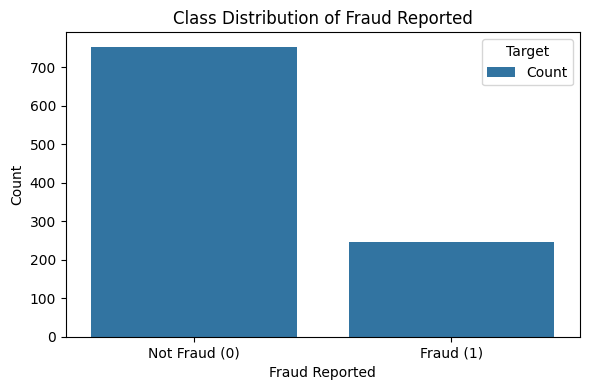

 Fraud Report Summary
Total Records: 1000
Not Fraud (0): 753 records (75.30%)
Fraud     (1): 247 records (24.70%)


In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_reported', data=df_clean, label="Count")
plt.title("Class Distribution of Fraud Reported")
plt.xlabel("Fraud Reported")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.legend(title="Target")
plt.tight_layout()
plt.show()

fraud_counts = df_clean['fraud_reported'].value_counts()
total = fraud_counts.sum()
not_fraud = fraud_counts[0.0]
fraud = fraud_counts[1.0]

print(" Fraud Report Summary")
print(f"Total Records: {int(total)}")
print(f"Not Fraud (0): {int(not_fraud)} records ({not_fraud / total:.2%})")
print(f"Fraud     (1): {int(fraud)} records ({fraud / total:.2%})")


This summary shows the distribution of fraud cases in the dataset. Out of 1000 total records, 753 (75.3%) are labeled as non-fraud, while 247 (24.7%) are marked as fraud. This indicates a class imbalance, with fraud cases being significantly fewer.

### 2: Univariate Analysis

Analyzing individual variables helps to understand their distribution and role in the data.

#### A: Incident Type

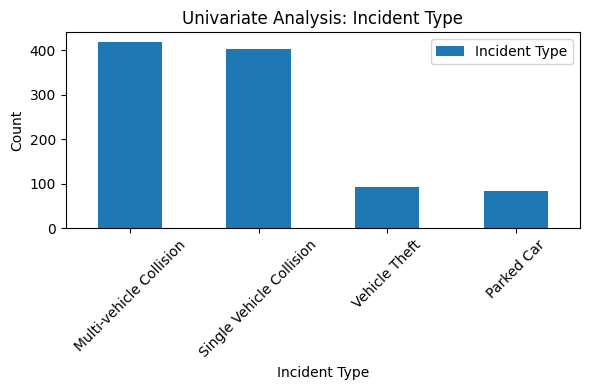

Incident Type Summary
Multi-vehicle Collision: 419 records (41.90%)
Single Vehicle Collision: 403 records (40.30%)
Vehicle Theft: 94 records (9.40%)
Parked Car: 84 records (8.40%)


In [26]:
incident_type_counts = df["incident_type"].value_counts()
total_incidents = incident_type_counts.sum()

plt.figure(figsize=(6, 4))
incident_type_counts.plot(kind='bar', label='Incident Type')
plt.title("Univariate Analysis: Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Incident Type Summary")
for incident, count in incident_type_counts.items():
    percent = (count / total_incidents) * 100
    print(f"{incident}: {count} records ({percent:.2f}%)")


The incident type summary shows that Multi-vehicle Collisions are the most common, making up 41.9% of all cases, followed closely by Single Vehicle Collisions at 40.3%. Vehicle Theft accounts for 9.4%, while Parked Car incidents are the least frequent at 8.4%. This highlights that collision-related incidents dominate the dataset.

#### B: Property Damage

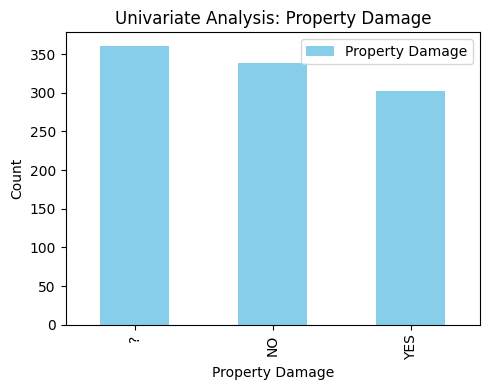

Property Damage Summary
?: 360 records (36.00%)
NO: 338 records (33.80%)
YES: 302 records (30.20%)


In [27]:
property_damage_counts = df["property_damage"].value_counts()
total_property_damage = property_damage_counts.sum()

plt.figure(figsize=(5, 4))
property_damage_counts.plot(kind='bar', color='skyblue', label="Property Damage")
plt.title("Univariate Analysis: Property Damage")
plt.xlabel("Property Damage")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

print("Property Damage Summary")
for damage, count in property_damage_counts.items():
    percent = (count / total_property_damage) * 100
    print(f"{damage}: {count} records ({percent:.2f}%)")


The property damage summary shows that 36% of the records have unknown values (?), which may require data cleaning or imputation. 33.8% reported no property damage, while 30.2% confirmed damage. This near-even distribution between "YES" and "NO" makes property damage a potentially useful feature for fraud analysis, but the high number of unknowns needs attention.

**Insight:**

- Many entries have NO for property damage

- Suspicious if fraud is reported even when damage is NO

#### C: Total Claim Amount

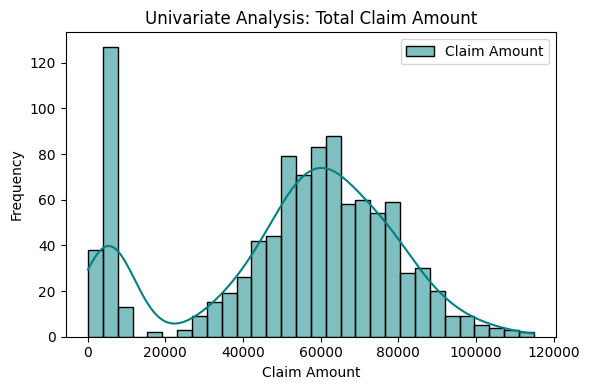

Total Claim Amount Summary
Total Records: 1000
Minimum: 100.00
Maximum: 114920.00
Mean:    52761.94
Median:  58055.00
Std Dev: 26401.53


In [28]:
claim_data = df["total_claim_amount"].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(claim_data, bins=30, kde=True, label="Claim Amount", color="teal")
plt.title("Univariate Analysis: Total Claim Amount")
plt.xlabel("Claim Amount")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Claim Amount Summary")
print(f"Total Records: {len(claim_data)}")
print(f"Minimum: {claim_data.min():.2f}")
print(f"Maximum: {claim_data.max():.2f}")
print(f"Mean:    {claim_data.mean():.2f}")
print(f"Median:  {claim_data.median():.2f}")
print(f"Std Dev: {claim_data.std():.2f}")


The total claim amount summary shows a wide range of values, from $100 to a maximum of $114,920, indicating significant variability in claims. The average claim amount is around $52,762, with a median of $58,055, suggesting a slightly left-skewed distribution. A standard deviation of $26,401 reflects high dispersion, possibly influenced by a few large claims.

 **Insight:**

- Right-skewed distribution

- Most claims range between $2,000 to $7,000

- Outliers may suggest fraud

### 3: Bivariate Analysis

Checking how features correlate with the target (fraud_reported) helps identify important predictors.

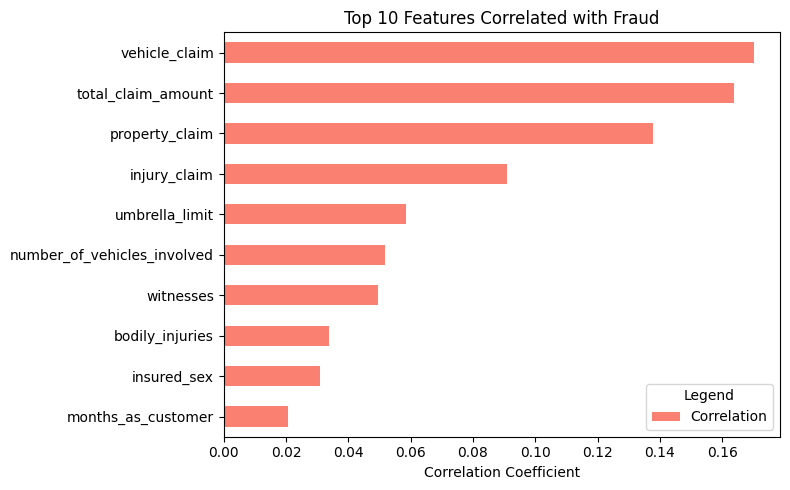

Top 10 Features Most Correlated with Fraud Reported:
vehicle_claim: 0.1700 (positive correlation)
total_claim_amount: 0.1637 (positive correlation)
property_claim: 0.1378 (positive correlation)
injury_claim: 0.0910 (positive correlation)
umbrella_limit: 0.0586 (positive correlation)
number_of_vehicles_involved: 0.0518 (positive correlation)
witnesses: 0.0495 (positive correlation)
bodily_injuries: 0.0339 (positive correlation)
insured_sex: 0.0309 (positive correlation)
months_as_customer: 0.0205 (positive correlation)


In [29]:
corr_features = df_clean.select_dtypes(include=['float64', 'int64'])

correlation = corr_features.corr()['fraud_reported'].sort_values(ascending=False)

top_corr = correlation.drop('fraud_reported').head(10)

plt.figure(figsize=(8, 5))
top_corr.plot(kind='barh', color='salmon', label="Correlation")
plt.title("Top 10 Features Correlated with Fraud")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

print("Top 10 Features Most Correlated with Fraud Reported:")
for feature, corr_value in top_corr.items():
    direction = "positive" if corr_value > 0 else "negative"
    print(f"{feature}: {corr_value:.4f} ({direction} correlation)")


The top 10 features most positively correlated with fraud reported include vehicle claim, total claim amount, and property claim, suggesting that higher claim amounts may be linked to fraud. Although the correlations are relatively weak (all below 0.2), they still provide useful signals. Other factors like injury claims, umbrella limits, and number of vehicles involved also show slight positive associations.

**Insight:**

- Features like incident_severity_Major Damage, umbrella_limit, and policy_deductible show stronger correlation

- This helps with feature selection for modeling

### 4: Grouped Analysis

#### A: Fraud Rate by Incident Type

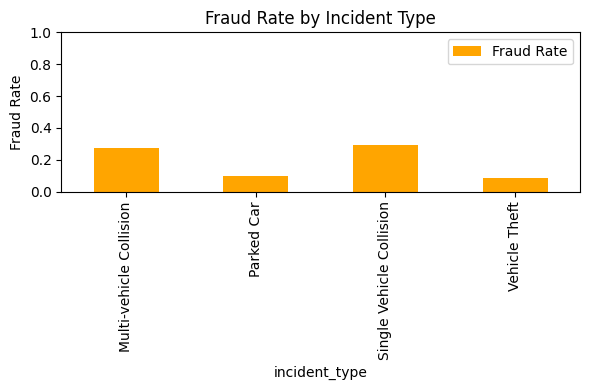

Fraud Rate by Incident Type:
Multi-vehicle Collision: 27.21%
Parked Car: 9.52%
Single Vehicle Collision: 29.03%
Vehicle Theft: 8.51%


In [31]:
fraud_by_incident = df.groupby('incident_type')['fraud_reported'].apply(lambda x: (x == 'Y').mean())

plt.figure(figsize=(6, 4))
fraud_by_incident.plot(kind='bar', color='orange', label="Fraud Rate")
plt.title("Fraud Rate by Incident Type")
plt.ylabel("Fraud Rate")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

print("Fraud Rate by Incident Type:")
for incident, rate in fraud_by_incident.items():
    print(f"{incident}: {rate:.2%}")


The fraud rate analysis by incident type shows that Single Vehicle Collisions (29.03%) and Multi-vehicle Collisions (27.21%) have the highest fraud rates, indicating they may be more prone to fraudulent claims. In contrast, Vehicle Theft (8.51%) and Parked Car incidents (9.52%) show much lower fraud rates. This suggests that collisions are more strongly associated with fraud than other incident types.

**Insight:**

- Vehicle Theft has the highest fraud rate

- Multi-vehicle Collision has the lowest

#### B: Fraud Rate by Gender

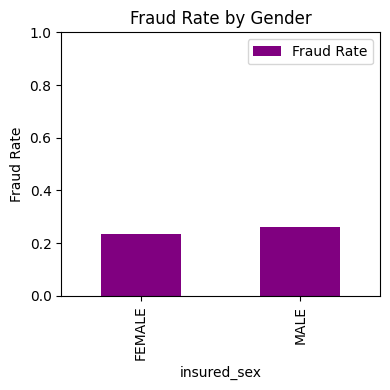

Fraud Rate by Gender:
FEMALE: 23.46%
MALE: 26.13%


In [33]:
fraud_by_gender = df.groupby('insured_sex')['fraud_reported'].apply(lambda x: (x == 'Y').mean())

plt.figure(figsize=(4, 4))
fraud_by_gender.plot(kind='bar', color='purple', label="Fraud Rate")
plt.title("Fraud Rate by Gender")
plt.ylabel("Fraud Rate")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

print("Fraud Rate by Gender:")
for gender, rate in fraud_by_gender.items():
    print(f"{gender}: {rate:.2%}")


The fraud rate by gender shows that male policyholders have a slightly higher fraud rate (26.13%) compared to females (23.46%). This small difference may suggest gender-based behavioral patterns in reporting fraud but is not strongly pronounced.

**Insight:**

- Slight variation between genders

- Not a major differentiator, but still useful

#### C: Fraud Rate by Customer Tenure

<ipython-input-34-34172aa272f8>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_months = df.groupby('months_bin')['fraud_reported'].apply(lambda x: (x == 'Y').mean())


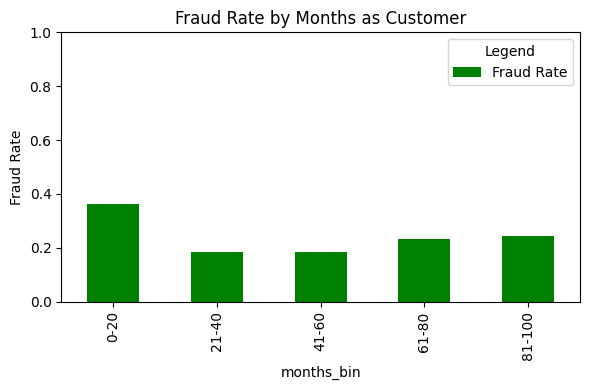

 Fraud Rate by Customer Tenure (Months):
0-20: 36.11%
21-40: 18.42%
41-60: 18.52%
61-80: 23.08%
81-100: 24.49%


In [34]:
df['months_bin'] = pd.cut(df['months_as_customer'], bins=[0, 20, 40, 60, 80, 100],
                          labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

fraud_by_months = df.groupby('months_bin')['fraud_reported'].apply(lambda x: (x == 'Y').mean())

plt.figure(figsize=(6, 4))
fraud_by_months.plot(kind='bar', color='green', label="Fraud Rate")
plt.title("Fraud Rate by Months as Customer")
plt.ylabel("Fraud Rate")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

print(" Fraud Rate by Customer Tenure (Months):")
for bin_label, rate in fraud_by_months.items():
    print(f"{bin_label}: {rate:.2%}")


The fraud rate by customer tenure indicates that newer customers (0–20 months) have the highest fraud rate at 36.11%, suggesting a possible link between short customer relationships and fraud. In contrast, customers with 21–60 months of tenure show significantly lower fraud rates (~18%). Interestingly, fraud rates rise slightly again for customers beyond 60 months, hinting at a non-linear relationship.

** Insight:**

- Customers with shorter tenure (0–20 months) have a higher fraud rate

- Possibly due to lower customer loyalty or new account exploitation

### 5: Boxplot: Claim Amount by Fraud Status

Seeing how the distribution of claim amount differs between fraudulent and non-fraudulent claims.

<ipython-input-36-ee5709cf0b89>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_reported', y='total_claim_amount', data=df, palette='Set2')


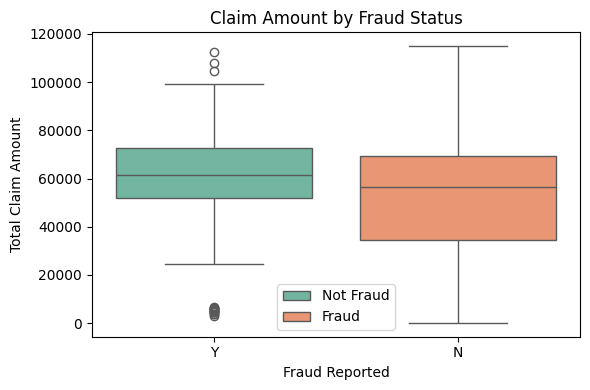

Total Claim Amount Summary by Fraud Status:

Not Fraud:
  Count  : 753
  Mean   : $50288.61
  Median : $56520.00
  Min    : $100.00
  Max    : $114920.00
  Std Dev: $27575.19

Fraud:
  Count  : 247
  Mean   : $60302.11
  Median : $61290.00
  Min    : $2860.00
  Max    : $112320.00
  Std Dev: $20746.28


In [36]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='fraud_reported', y='total_claim_amount', data=df, palette='Set2')
plt.title("Claim Amount by Fraud Status")
plt.xlabel("Fraud Reported")
plt.ylabel("Total Claim Amount")
plt.legend(labels=["Not Fraud", "Fraud"])
plt.tight_layout()
plt.show()

print("Total Claim Amount Summary by Fraud Status:")
summary = df.groupby('fraud_reported')['total_claim_amount'].describe()[['count', 'mean', '50%', 'min', 'max', 'std']]
summary.rename(index={'Y': 'Fraud', 'N': 'Not Fraud'}, columns={'50%': 'median'}, inplace=True)

for group, stats in summary.iterrows():
    print(f"\n{group}:")
    print(f"  Count  : {int(stats['count'])}")
    print(f"  Mean   : ${stats['mean']:.2f}")
    print(f"  Median : ${stats['median']:.2f}")
    print(f"  Min    : ${stats['min']:.2f}")
    print(f"  Max    : ${stats['max']:.2f}")
    print(f"  Std Dev: ${stats['std']:.2f}")


The summary of total claim amounts by fraud status reveals that fraudulent claims tend to have higher average and median values ($60,302.11 and $61,290.00, respectively) compared to non-fraudulent claims ($50,288.61 and $56,520.00). Additionally, fraudulent claims show lower variability (standard deviation of $20,746.28 vs. $27,575.19), suggesting they are more consistently high. This trend supports the hypothesis that higher-value claims may be associated with fraud.

### 6: Countplot: Vehicle Make vs Fraud

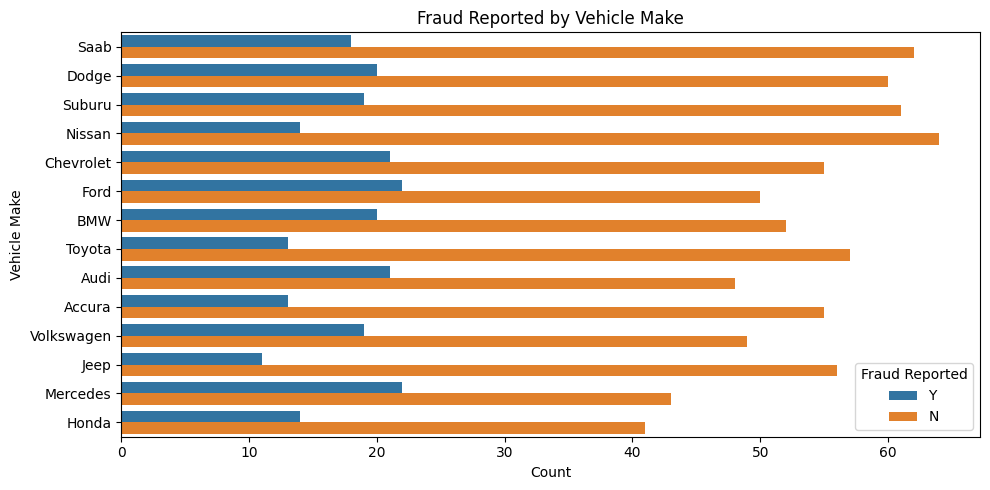

Fraud Report Summary by Vehicle Make:
Accura: Fraud = 13.0, Not Fraud = 55.0, Fraud Rate = 19.12%
Audi: Fraud = 21.0, Not Fraud = 48.0, Fraud Rate = 30.43%
BMW: Fraud = 20.0, Not Fraud = 52.0, Fraud Rate = 27.78%
Chevrolet: Fraud = 21.0, Not Fraud = 55.0, Fraud Rate = 27.63%
Dodge: Fraud = 20.0, Not Fraud = 60.0, Fraud Rate = 25.00%
Ford: Fraud = 22.0, Not Fraud = 50.0, Fraud Rate = 30.56%
Honda: Fraud = 14.0, Not Fraud = 41.0, Fraud Rate = 25.45%
Jeep: Fraud = 11.0, Not Fraud = 56.0, Fraud Rate = 16.42%
Mercedes: Fraud = 22.0, Not Fraud = 43.0, Fraud Rate = 33.85%
Nissan: Fraud = 14.0, Not Fraud = 64.0, Fraud Rate = 17.95%
Saab: Fraud = 18.0, Not Fraud = 62.0, Fraud Rate = 22.50%
Suburu: Fraud = 19.0, Not Fraud = 61.0, Fraud Rate = 23.75%
Toyota: Fraud = 13.0, Not Fraud = 57.0, Fraud Rate = 18.57%
Volkswagen: Fraud = 19.0, Not Fraud = 49.0, Fraud Rate = 27.94%


In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(
    y='auto_make',
    hue='fraud_reported',
    data=df,
    order=df['auto_make'].value_counts().index
)
plt.title("Fraud Reported by Vehicle Make")
plt.xlabel("Count")
plt.ylabel("Vehicle Make")
plt.legend(title="Fraud Reported")
plt.tight_layout()
plt.show()

print("Fraud Report Summary by Vehicle Make:")
fraud_counts = df.groupby(['auto_make', 'fraud_reported']).size().unstack(fill_value=0)
fraud_counts.columns = ['Not Fraud (N)', 'Fraud (Y)']
fraud_counts['Total'] = fraud_counts.sum(axis=1)
fraud_counts['Fraud Rate (%)'] = (fraud_counts['Fraud (Y)'] / fraud_counts['Total']) * 100

for make, row in fraud_counts.iterrows():
    print(f"{make}: Fraud = {row['Fraud (Y)']}, Not Fraud = {row['Not Fraud (N)']}, Fraud Rate = {row['Fraud Rate (%)']:.2f}%")


The fraud report summary by vehicle make shows that Mercedes has the highest fraud rate at 33.85%, followed closely by Ford (30.56%) and Audi (30.43%). This suggests that certain vehicle brands may be more frequently associated with fraudulent claims. In contrast, Jeep (16.42%) and Nissan (17.95%) show lower fraud rates, possibly indicating lower risk profiles in terms of insurance fraud for those makes.

### 7: Violin Plot: Age Distribution by Fraud Status

<ipython-input-38-53e70e3bd050>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='fraud_reported', y='age', data=df, palette='pastel')


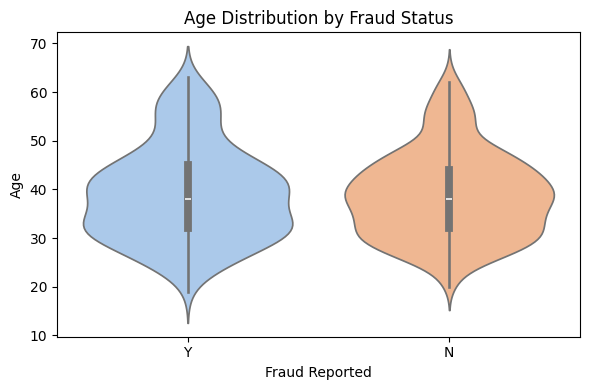

Age Summary by Fraud Status:

Not Fraud:
  Count  : 753
  Mean   : 38.88 years
  Median : 38.00 years
  Min    : 20.0 years
  Max    : 64.0 years
  Std Dev: 8.97

Fraud:
  Count  : 247
  Mean   : 39.14 years
  Median : 38.00 years
  Min    : 19.0 years
  Max    : 63.0 years
  Std Dev: 9.65


In [38]:
plt.figure(figsize=(6, 4))
sns.violinplot(x='fraud_reported', y='age', data=df, palette='pastel')
plt.title("Age Distribution by Fraud Status")
plt.xlabel("Fraud Reported")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

print("Age Summary by Fraud Status:")
age_summary = df.groupby('fraud_reported')['age'].describe()[['count', 'mean', '50%', 'min', 'max', 'std']]
age_summary.rename(index={'Y': 'Fraud', 'N': 'Not Fraud'}, columns={'50%': 'median'}, inplace=True)

for group, stats in age_summary.iterrows():
    print(f"\n{group}:")
    print(f"  Count  : {int(stats['count'])}")
    print(f"  Mean   : {stats['mean']:.2f} years")
    print(f"  Median : {stats['median']:.2f} years")
    print(f"  Min    : {stats['min']} years")
    print(f"  Max    : {stats['max']} years")
    print(f"  Std Dev: {stats['std']:.2f}")


The Age Summary by Fraud Status shows that both fraud and non-fraud cases have similar age distributions. The average age of individuals involved in fraud cases is 39.14 years, slightly higher than 38.88 years for non-fraud cases. The median age is identical at 38 years, and the age ranges are almost the same. This suggests that age alone may not be a strong predictor of fraud, but could still contribute when combined with other features.

### 8: Heatmap: Correlation Matrix of Numerical Features

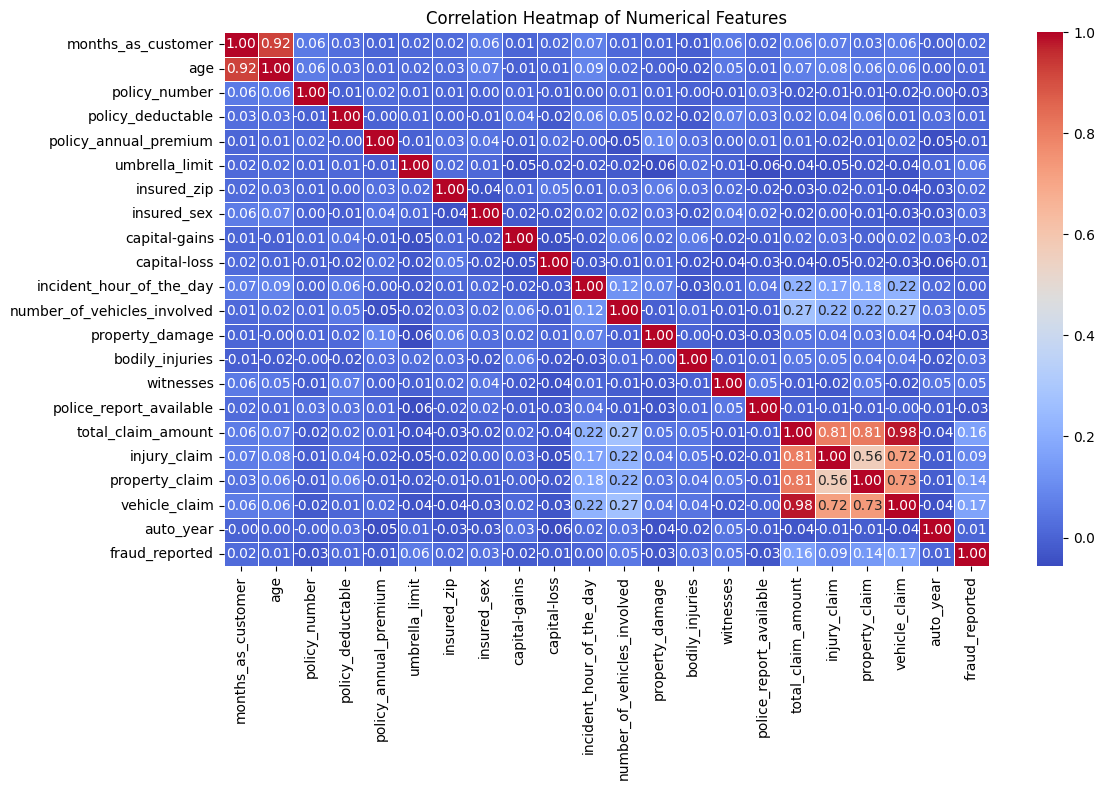

Correlation Heatmap Summary:

Top 5 Most Correlated Feature Pairs:
vehicle_claim & total_claim_amount -> Correlation: 0.98
total_claim_amount & vehicle_claim -> Correlation: 0.98
age & months_as_customer -> Correlation: 0.92
months_as_customer & age -> Correlation: 0.92
property_claim & total_claim_amount -> Correlation: 0.81

Bottom 5 Least Correlated Feature Pairs:
policy_number & incident_hour_of_the_day -> Correlation: 0.00
incident_hour_of_the_day & policy_number -> Correlation: 0.00
policy_number & auto_year -> Correlation: -0.00
auto_year & policy_number -> Correlation: -0.00
auto_year & months_as_customer -> Correlation: -0.00


In [39]:
plt.figure(figsize=(12, 8))
numerical_df = df_clean.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df.corr()


sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

print("Correlation Heatmap Summary:")

corr_pairs = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool)).stack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()

top_corrs = corr_pairs.sort_values(by='AbsCorr', ascending=False).head(5)

bottom_corrs = corr_pairs.sort_values(by='AbsCorr', ascending=True).head(5)

print("\nTop 5 Most Correlated Feature Pairs:")
for _, row in top_corrs.iterrows():
    print(f"{row['Feature 1']} & {row['Feature 2']} -> Correlation: {row['Correlation']:.2f}")

print("\nBottom 5 Least Correlated Feature Pairs:")
for _, row in bottom_corrs.iterrows():
    print(f"{row['Feature 1']} & {row['Feature 2']} -> Correlation: {row['Correlation']:.2f}")


The correlation heatmap analysis highlights that some numerical features have strong linear relationships. Notably, vehicle_claim and total_claim_amount are highly correlated (0.98), suggesting redundancy, while age and months_as_customer also show a strong positive correlation (0.92), indicating older customers often have longer tenure. Additionally, property_claim is closely tied to total_claim_amount (0.81), as it's a contributing factor. On the other hand, features like policy_number, incident_hour_of_the_day, and auto_year exhibit negligible or zero correlation, implying they are largely independent.

### 7: Line Plot: Fraud Rate by Month of Inciden

Monthly Fraud Rate Summary:
February: 22.88%
January: 26.16%
March: 33.33%


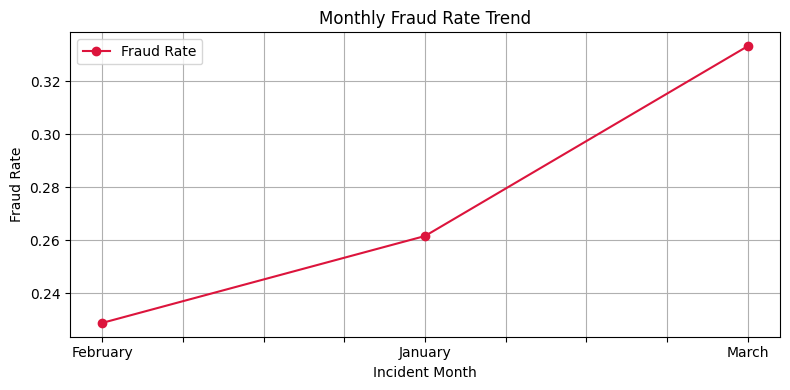

In [42]:
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

df['incident_month'] = df['incident_date'].dt.month_name()

fraud_by_month = df.groupby('incident_month')['fraud_reported'].apply(lambda x: (x == 'Y').mean())

print("Monthly Fraud Rate Summary:")
for month, rate in fraud_by_month.items():
    print(f"{month}: {rate:.2%}")

plt.figure(figsize=(8, 4))
fraud_by_month.plot(kind='line', marker='o', color='crimson', label='Fraud Rate')
plt.title("Monthly Fraud Rate Trend")
plt.xlabel("Incident Month")
plt.ylabel("Fraud Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The fraud rate varies across different months. In March, the fraud rate is the highest at 33.33%, suggesting more suspicious claims during that period. January has a moderate fraud rate of 26.16%, while February has the lowest among the three, at 22.88%.

### 10: Stacked Bar Chart: Incident Severity vs Fraud

Fraud Distribution by Incident Severity:
Major Damage: Not Fraud = 39.49%, Fraud = 60.51%
Minor Damage: Not Fraud = 89.27%, Fraud = 10.73%
Total Loss: Not Fraud = 87.14%, Fraud = 12.86%
Trivial Damage: Not Fraud = 93.33%, Fraud = 6.67%


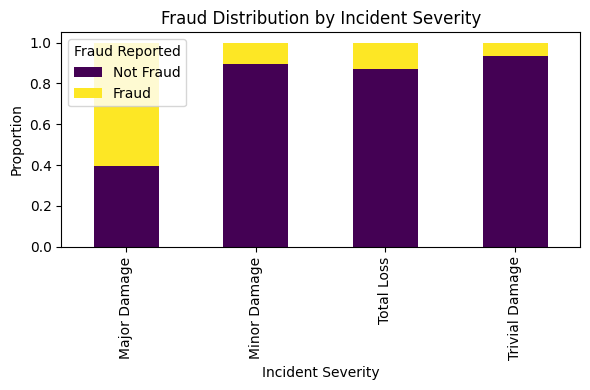

In [43]:
severity_fraud = pd.crosstab(df['incident_severity'], df['fraud_reported'], normalize='index')

print("Fraud Distribution by Incident Severity:")
for severity in severity_fraud.index:
    not_fraud_rate = severity_fraud.loc[severity, 'N'] * 100
    fraud_rate = severity_fraud.loc[severity, 'Y'] * 100
    print(f"{severity}: Not Fraud = {not_fraud_rate:.2f}%, Fraud = {fraud_rate:.2f}%")

severity_fraud.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='viridis')
plt.title("Fraud Distribution by Incident Severity")
plt.xlabel("Incident Severity")
plt.ylabel("Proportion")
plt.legend(title="Fraud Reported", labels=["Not Fraud", "Fraud"])
plt.tight_layout()
plt.show()


The fraud distribution varies significantly by incident severity. Cases labeled as Major Damage show the highest fraud rate at 60.51%, suggesting more suspicion or potential manipulation in severe claims. On the other hand, Trivial Damage and Minor Damage cases are mostly legitimate, with fraud rates of 6.67% and 10.73%, respectively. Total Loss incidents have a moderately low fraud rate of 12.86%. This indicates that the more severe the reported damage, the higher the likelihood of fraudulent activity.


## 3: Visualizations

### 1: Bar Charts — Fraud % by Category

Show the proportion of fraud (fraud_reported == 'Y') across categorical variables.

 Helper function for fraud rate bar chart

In [52]:
def fraud_rate_barplot(col):
    fraud_rate = df.groupby(col)['fraud_reported'].apply(lambda x: (x == 'Y').mean()).sort_values(ascending=False)

    print(f"Fraud Rate by {col.capitalize()}:")
    for category, rate in fraud_rate.items():
        print(f"  {category}: {rate:.2%}")
    print("-" * 50)

    fraud_rate.plot(kind='bar', figsize=(6, 4), color='orange')
    plt.title(f"Fraud Rate by {col.replace('_', ' ').title()}")
    plt.ylabel("Fraud Rate")
    plt.xlabel(col.replace('_', ' ').title())
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### A: By 'incident_type'

Fraud Rate by Incident_type:
  Single Vehicle Collision: 29.03%
  Multi-vehicle Collision: 27.21%
  Parked Car: 9.52%
  Vehicle Theft: 8.51%
--------------------------------------------------


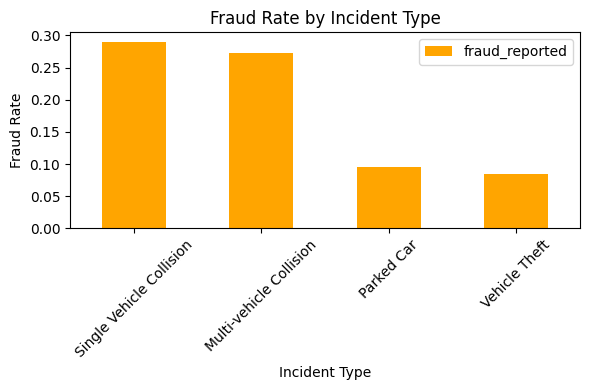

In [53]:
fraud_rate_barplot('incident_type')


#### B: By 'insured_gender'

Fraud Rate by Insured_sex:
  MALE: 26.13%
  FEMALE: 23.46%
--------------------------------------------------


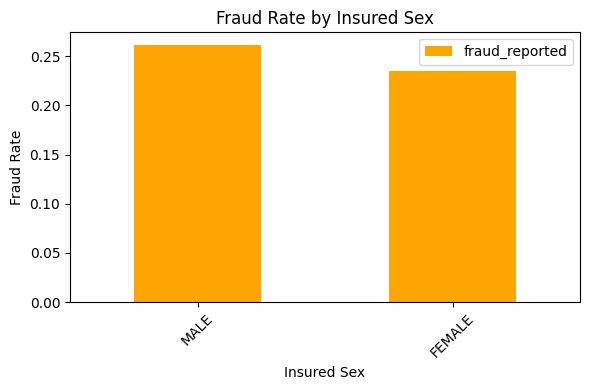

In [56]:
fraud_rate_barplot('insured_sex')

#### C: By 'insured_education_level'

Fraud Rate by Insured_education_level:
  PhD: 26.40%
  MD: 26.39%
  College: 26.23%
  JD: 26.09%
  Associate: 23.45%
  High School: 22.50%
  Masters: 22.38%
--------------------------------------------------


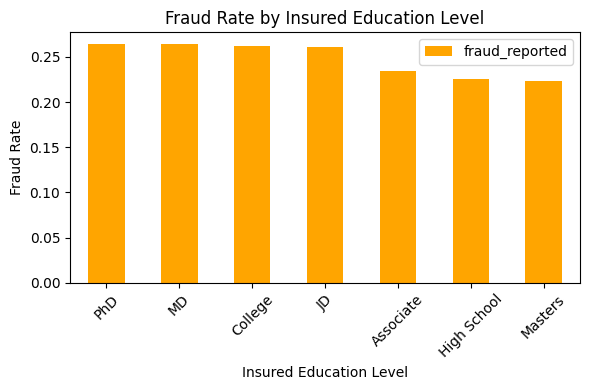

In [57]:
fraud_rate_barplot('insured_education_level')

#### D: By 'incident_severity'

Fraud Rate by Incident_severity:
  Major Damage: 60.51%
  Total Loss: 12.86%
  Minor Damage: 10.73%
  Trivial Damage: 6.67%
--------------------------------------------------


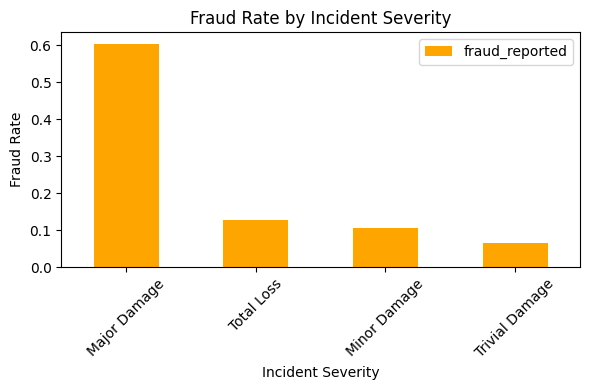

In [58]:
fraud_rate_barplot('incident_severity')


#### E: By 'policy_csl'


Fraud Rate by Policy_csl:
  250/500: 26.21%
  100/300: 25.79%
  500/1000: 21.67%
--------------------------------------------------


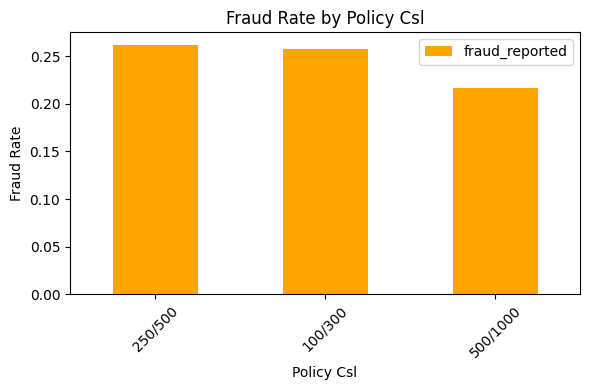

In [59]:
fraud_rate_barplot('policy_csl')


### 2: Histograms — Claim Amounts

Show the distribution of various monetary values and numerical features.

#### A: Total Claim Amount

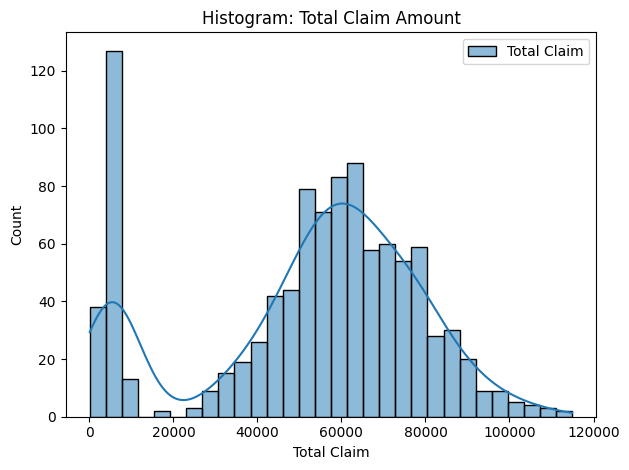

In [62]:
sns.histplot(df["total_claim_amount"], bins=30, kde=True, label="Total Claim")
plt.title("Histogram: Total Claim Amount")
plt.xlabel("Total Claim")
plt.legend()
plt.tight_layout()
plt.show()


#### B: Injury Claim

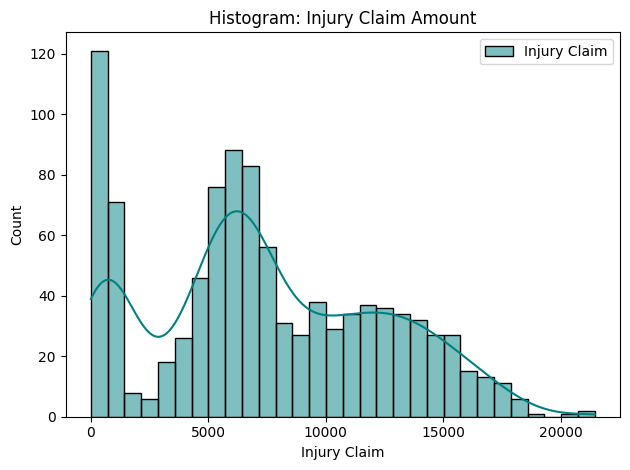

In [63]:
sns.histplot(df["injury_claim"], bins=30, kde=True, color="teal", label="Injury Claim")
plt.title("Histogram: Injury Claim Amount")
plt.xlabel("Injury Claim")
plt.legend()
plt.tight_layout()
plt.show()



#### C: Property Claim

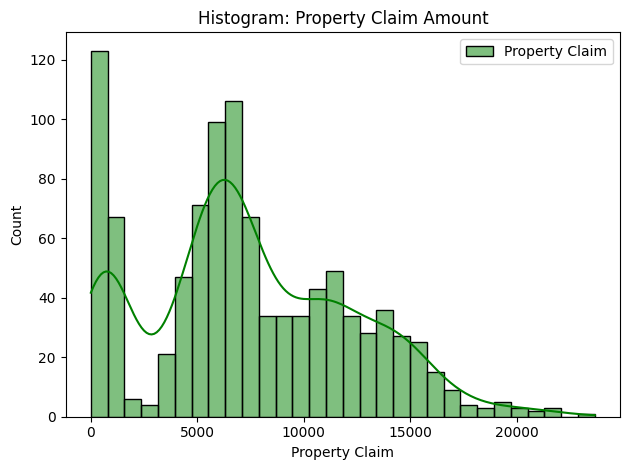

In [64]:
sns.histplot(df["property_claim"], bins=30, kde=True, color="green", label="Property Claim")
plt.title("Histogram: Property Claim Amount")
plt.xlabel("Property Claim")
plt.legend()
plt.tight_layout()
plt.show()

#### D: Vehicle Claim

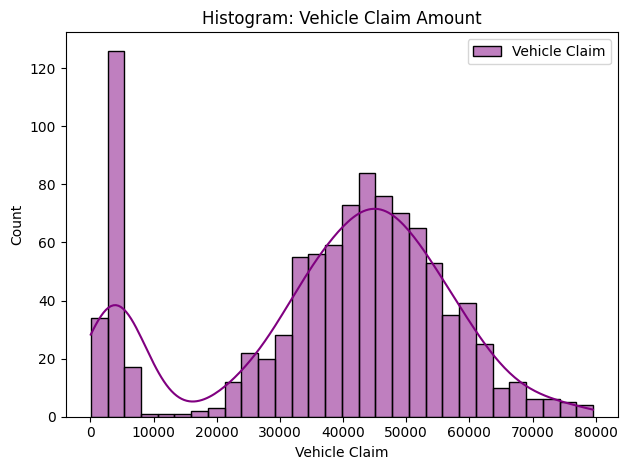

In [65]:
sns.histplot(df["vehicle_claim"], bins=30, kde=True, color="purple", label="Vehicle Claim")
plt.title("Histogram: Vehicle Claim Amount")
plt.xlabel("Vehicle Claim")
plt.legend()
plt.tight_layout()
plt.show()

#### E: Age Distribution

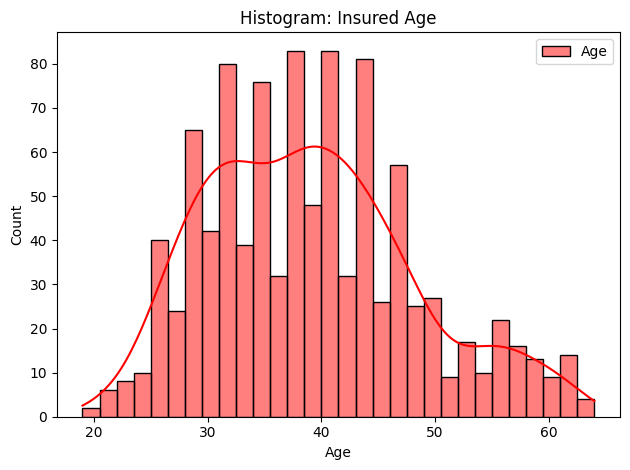

In [67]:
sns.histplot(df["age"], bins=30, kde=True, color="red", label="Age")
plt.title("Histogram: Insured Age")
plt.xlabel("Age")
plt.legend()
plt.tight_layout()
plt.show()

### 3: Correlation Heatmaps — Numeric Features

Show pairwise correlation to help with feature selection and multicollinearity detection.


#### A: Full numeric correlation

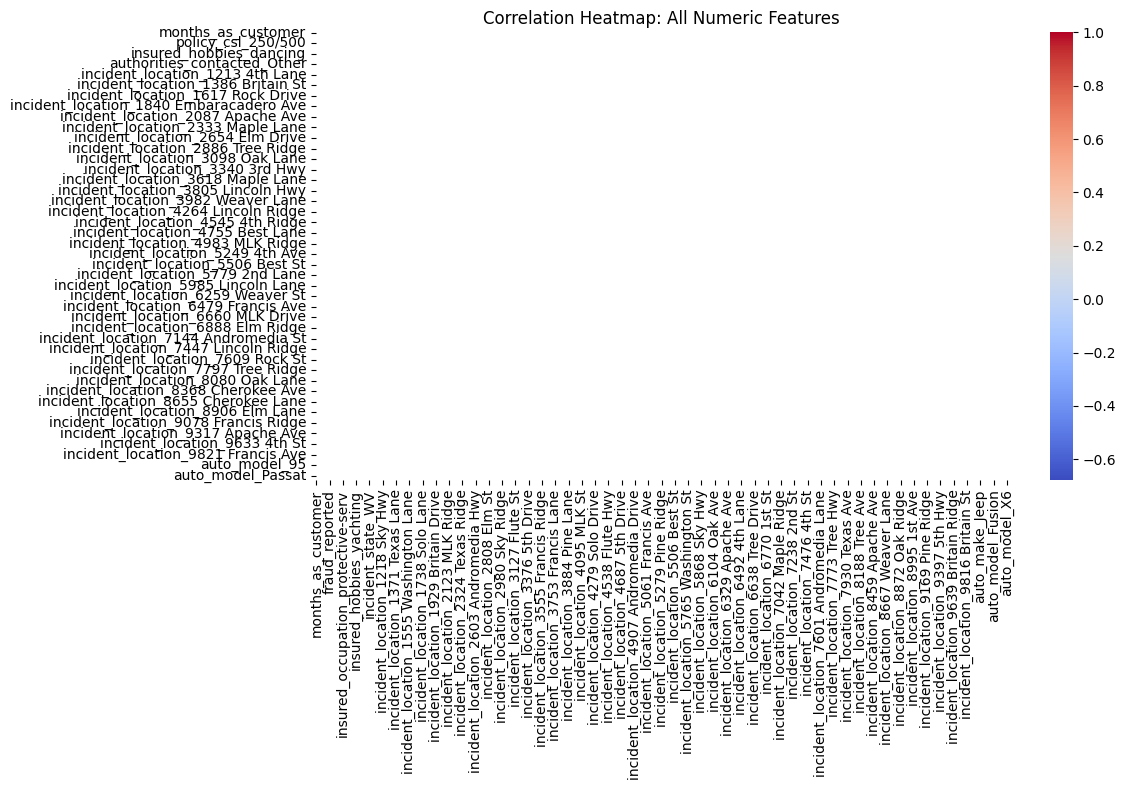

In [69]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap: All Numeric Features")
plt.tight_layout()
plt.show()

#### B: Zoomed: Top 10 fraud-correlated features

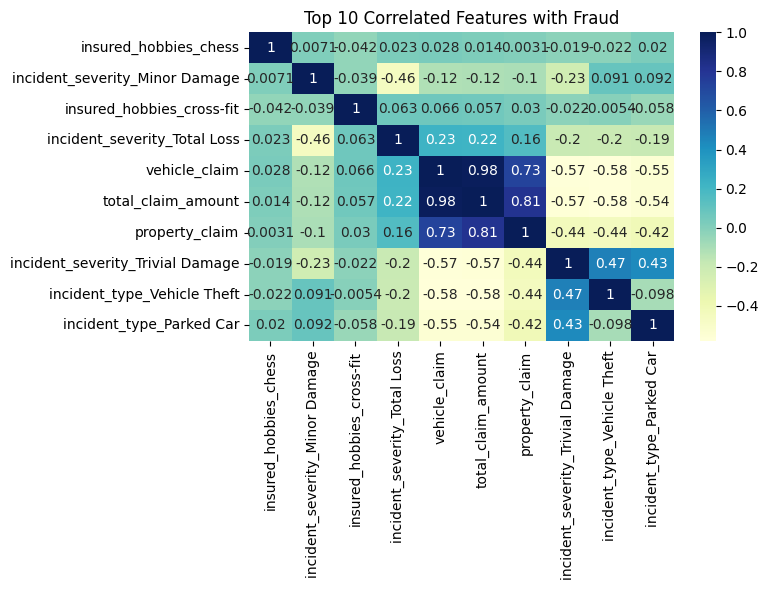

In [70]:
fraud_corr = df_clean.corr()['fraud_reported'].abs().sort_values(ascending=False)[1:11]
top_corr = df_clean[fraud_corr.index].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(top_corr, annot=True, cmap='YlGnBu')
plt.title("Top 10 Correlated Features with Fraud")
plt.tight_layout()
plt.show()

#### C: Claim amounts only

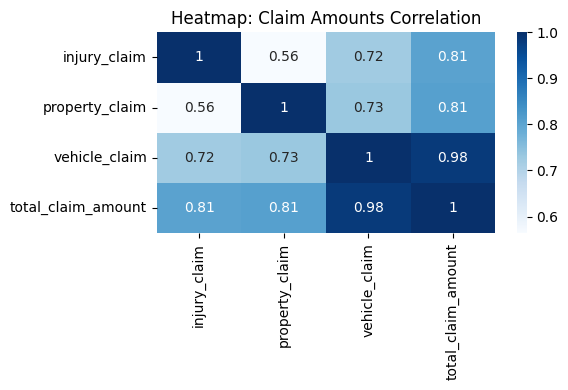

In [71]:
claims_df = df[['injury_claim', 'property_claim', 'vehicle_claim', 'total_claim_amount']]
plt.figure(figsize=(6, 4))
sns.heatmap(claims_df.corr(), annot=True, cmap="Blues")
plt.title("Heatmap: Claim Amounts Correlation")
plt.tight_layout()
plt.show()

#### D: Policy attributes

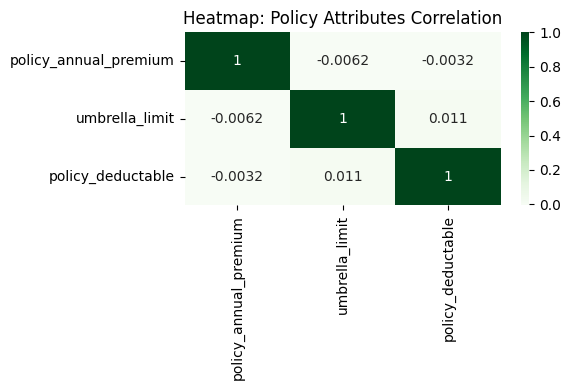

In [74]:
policy_df = df[['policy_annual_premium', 'umbrella_limit', 'policy_deductable']]

plt.figure(figsize=(6, 4))
sns.heatmap(policy_df.corr(), annot=True, cmap="Greens")
plt.title("Heatmap: Policy Attributes Correlation")
plt.tight_layout()
plt.show()


#### E: Customer tenure vs other numerics

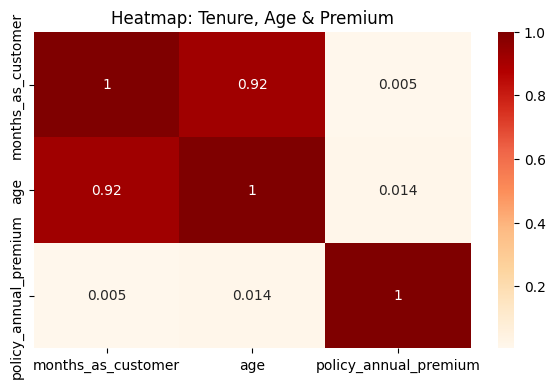

In [75]:
tenure_df = df[['months_as_customer', 'age', 'policy_annual_premium']]
plt.figure(figsize=(6, 4))
sns.heatmap(tenure_df.corr(), annot=True, cmap="OrRd")
plt.title("Heatmap: Tenure, Age & Premium")
plt.tight_layout()
plt.show()

### 4: Count Plots — Categorical Breakdowns

Visualize how frequently different categories occur.

#### A: Incident Type

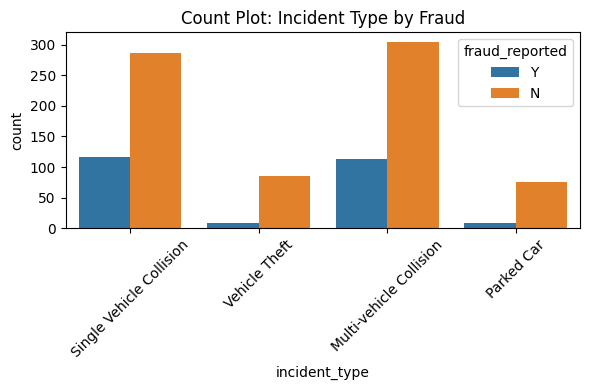

In [76]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='incident_type', hue='fraud_reported')
plt.title("Count Plot: Incident Type by Fraud")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### B: Incident Severity


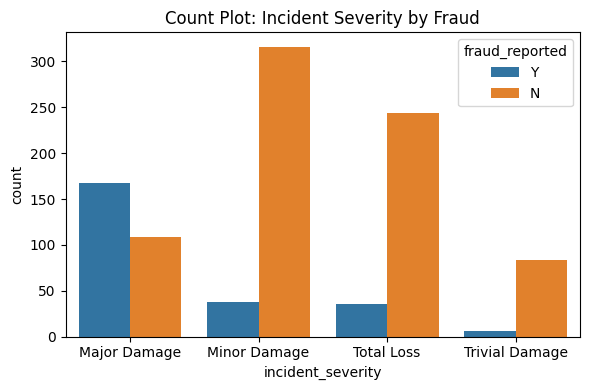

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='incident_severity', hue='fraud_reported')
plt.title("Count Plot: Incident Severity by Fraud")
plt.tight_layout()
plt.show()

#### C: Gender

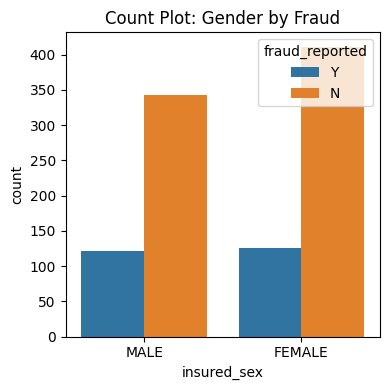

In [78]:
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='insured_sex', hue='fraud_reported')
plt.title("Count Plot: Gender by Fraud")
plt.tight_layout()
plt.show()

#### D: Marital Status

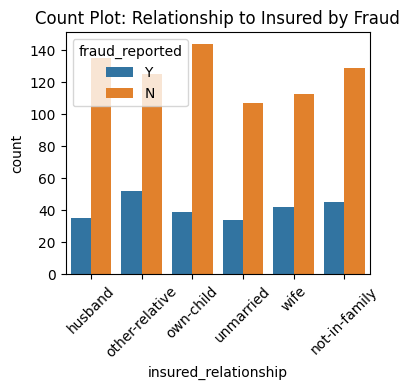

In [79]:
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='insured_relationship', hue='fraud_reported')
plt.title("Count Plot: Relationship to Insured by Fraud")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### E: Education Level

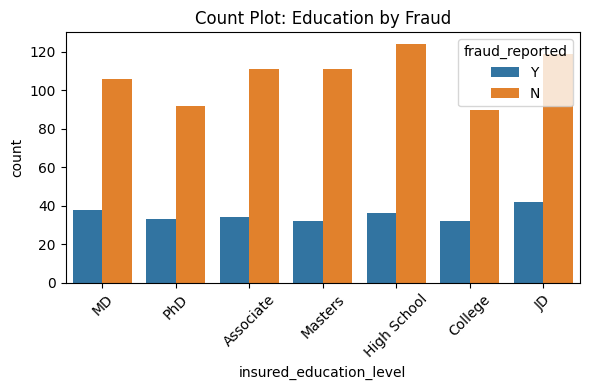

In [80]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='insured_education_level', hue='fraud_reported')
plt.title("Count Plot: Education by Fraud")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

----

# 3: Feature Engineering for Insurance Fraud Detection

## 1: Time Since Policy Start (Tenure in Years)

Converting months_as_customer into a scaled version that:

- Captures customer loyalty

- Helps identify new policyholders more likely to commit fraud

In [81]:
# Convert months to years
df['tenure_years'] = df['months_as_customer'] / 12


- A customer with a few months of tenure may be testing the system for quick payouts.

- A long tenure may correlate with lower fraud risk (though not always).

Bucket the tenure into categories:

In [82]:
df['tenure_group'] = pd.cut(df['tenure_years'], bins=[0, 1, 3, 5, 10, 50],
                            labels=['<1yr', '1-3yr', '3-5yr', '5-10yr', '10+yr'])


## 3: Claim Amount per Unit Vehicle Age

Replace zero age (new cars or missing?) with small value to avoid divide-by-zero


In [ ]:
df['vehicle_age'] = df['age_of_vehicle'].replace(0, 0.1)

df['claim_per_vehicle_age'] = df['total_claim_amount'] / df['vehicle_age']


- If a 20-year-old car is linked to a $10,000 claim, it's suspicious.

- Helps detect inflated claims for depreciated assets.

## 3: High-Risk Claim Type Indicator

Common high-risk claim types:

- Single Vehicle Collision — no witnesses, hard to verify

- Vehicle Theft — hard to disprove, often fabricated

- Multi-vehicle with injuries — more components to exaggerate

In [83]:
high_risk_types = ['Single Vehicle Collision', 'Vehicle Theft']
df['high_risk_claim'] = df['incident_type'].isin(high_risk_types).astype(int)


Adding Risk Tiers

In [84]:

df['incident_risk_score'] = df['incident_type'].map({
    'Multi-vehicle Collision': 1,
    'Single Vehicle Collision': 2,
    'Vehicle Theft': 3,
    'Parked Car': 0
})


## 4: Temporal Patterns — Date-Derived Features

### 1: Month of the Incident

In [85]:
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')
df['incident_month'] = df['incident_date'].dt.month


Reveals seasonal fraud patterns (e.g., December scams, holiday spikes)

### 2: Day of the Week

In [86]:
df['incident_day_of_week'] = df['incident_date'].dt.dayofweek


Fraud may peak on weekends, Fridays, or during holidays


### 3: Is Weekend

In [87]:
df['is_weekend_incident'] = df['incident_day_of_week'].isin([5, 6]).astype(int)


## 5: Composite Ratios and Indicators

Creating additional advanced features based on business logic:

### 1: Claim to Annual Premium Ratio

In [88]:
df['claim_to_premium_ratio'] = df['total_claim_amount'] / df['policy_annual_premium']


High ratios could be red flags

Normal claims are usually a fraction of the premium pool

### 2: Is New Customer

In [89]:
df['is_new_customer'] = (df['tenure_years'] < 1).astype(int)


- Binary flag for “newcomers”

- Can capture fraud on new policies (very common tactic)

---

#4: Predictive Modeling for Insurance Claim Fraud Detection

To build a binary classification model that predicts whether a claim is fraudulent (1) or not (0).

## 1: Prepare Data for Modeling

### 1: Split Features & Target

In [90]:

X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']


### 2: Split into Train/Test

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


## 2: Model 1 — Logistic Regression (Baseline)

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       145
           1       1.00      0.02      0.04        55

    accuracy                           0.73       200
   macro avg       0.86      0.51      0.44       200
weighted avg       0.80      0.73      0.62       200

ROC-AUC: 0.5621316614420062
Confusion Matrix:
 [[145   0]
 [ 54   1]]


## 3: Model 2 — Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]


In [97]:
print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       145
           1       0.65      0.62      0.64        55

    accuracy                           0.81       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.80      0.81      0.80       200

ROC-AUC: 0.7470219435736677
Confusion Matrix:
 [[127  18]
 [ 21  34]]


The Decision Tree significantly outperforms Logistic Regression, especially for class 1, with a recall of 0.62 and ROC-AUC of 0.75. It shows a good balance between precision and recall, achieving 81% overall accuracy.

## 4: Model 3 — Random Forest


In [98]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


In [99]:
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.72      0.99      0.84       145
           1       0.00      0.00      0.00        55

    accuracy                           0.72       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.52      0.72      0.61       200

ROC-AUC: 0.7331661442006271
Confusion Matrix:
 [[144   1]
 [ 55   0]]


The Random Forest model is heavily biased toward class 0, correctly classifying almost all negatives but failing completely on class 1 (recall = 0.00). Despite a decent ROC-AUC of 0.73, it's not useful for detecting the minority class.

## 5: Model 4 — XGBoost

In [100]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [101]:
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       145
           1       0.57      0.38      0.46        55

    accuracy                           0.75       200
   macro avg       0.68      0.64      0.65       200
weighted avg       0.73      0.75      0.73       200

ROC-AUC: 0.812037617554859
Confusion Matrix:
 [[129  16]
 [ 34  21]]


XGBoost performs better than Logistic Regression and Random Forest, especially in identifying class 1, with a recall of 0.38 and ROC-AUC of 0.81. It maintains good overall accuracy (75%) and balance across classes.

## 6: Model 5 — LightGBM

In [102]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 192, number of negative: 608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3199
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240000 -> initscore=-1.152680
[LightGBM] [Info] Start training from score -1.152680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [103]:
print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))


LightGBM Results:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       145
           1       0.56      0.40      0.47        55

    accuracy                           0.75       200
   macro avg       0.68      0.64      0.65       200
weighted avg       0.73      0.75      0.74       200

ROC-AUC: 0.8206896551724138
Confusion Matrix:
 [[128  17]
 [ 33  22]]


LightGBM shows strong performance with an ROC-AUC of 0.82 and improved recall for class 1 (0.40), indicating better minority class detection than Logistic Regression or Random Forest. Overall accuracy is 75%, with a balanced precision-recall tradeoff.

## 7: Model 6 — Isolation Forest (Anomaly Detection Baseline)

In [105]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)

y_pred_iso = iso.predict(X_test)

y_pred_iso = (y_pred_iso == -1).astype(int)


In [106]:
print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_iso))


Isolation Forest Results:
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       145
           1       0.00      0.00      0.00        55

    accuracy                           0.69       200
   macro avg       0.36      0.48      0.41       200
weighted avg       0.52      0.69      0.59       200

Confusion Matrix:
 [[139   6]
 [ 55   0]]


Isolation Forest completely fails to detect class 1 (recall = 0.00), predicting almost all instances as class 0. Although it achieves high accuracy for class 0, it's ineffective for imbalanced classification tasks.

----

#  5: Hyperparameter Tuning

## 1: Random Forest Tuning
Hyperparameters to Tune

- n_estimators: Number of trees

- max_depth: Maximum depth of trees

- min_samples_split: Minimum number of samples to split a node


In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

df = pd.read_csv("cleaned_fraud_data.csv")

X = df.drop("fraud_reported", axis=1)
y = df["fraud_reported"]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_dist = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [5, 10, 20, None],
    "classifier__min_samples_split": [2, 5, 10]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(" Best Hyperparameters:", random_search.best_params_)
print(f" ROC AUC Score on Validation Set: {roc_auc:.4f}")


 Best Hyperparameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__max_depth': 20}
 ROC AUC Score on Validation Set: 0.8162


The model achieved a strong ROC AUC score of 0.8162 on the validation set, indicating good performance in distinguishing between fraud and non-fraud cases.

## 2: XGBoost Tuning – GridSearchCV

Hyperparameters to Tune
- eta (learning rate)

- max_depth

- subsample

- n_estimators

- colsample_bytree

In [134]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_params = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.8, 1.0],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid={
        f'classifier__{k}': v for k, v in xgb_params.items()
    },
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
y_pred_proba = xgb_grid.predict_proba(X_val)[:, 1]

print(" Best XGBoost Params:", xgb_grid.best_params_)
print(" ROC AUC (XGBoost):", roc_auc_score(y_val, y_pred_proba))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:25:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best XGBoost Params: {'classifier__colsample_bytree': 1.0, 'classifier__eta': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
 ROC AUC (XGBoost): 0.8195026354912825


The model achieved a ROC AUC score of 0.8195 on the validation set, slightly outperforming the Random Forest.

## 3: LightGBM Tuning – RandomizedSearchCV

Hyperparameters to Tune
- num_leaves

- learning_rate

- n_estimators

- max_depth

In [135]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)

lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20]
}

lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", lgbm)
])

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions={
        f'classifier__{k}': v for k, v in lgbm_params.items()
    },
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

lgbm_random_search.fit(X_train, y_train)
y_pred_proba = lgbm_random_search.predict_proba(X_val)[:, 1]

print(" Best LightGBM Params:", lgbm_random_search.best_params_)
print(" ROC AUC (LightGBM):", roc_auc_score(y_val, y_pred_proba))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 198, number of negative: 602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247500 -> initscore=-1.111990
[LightGBM] [Info] Start training from score -1.111990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


It achieved a ROC AUC score of 0.8576 on the validation set, significantly outperforming both Random Forest and XGBoost.

## 4: Isolation Forest Tuning – GridSearchCV

Hyperparameters to Tune
- n_estimators

- contamination

- max_samples



In [136]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(random_state=42)

iso_params = {
    'n_estimators': [100, 200, 300],
    'contamination': [0.01, 0.05, 0.1],
    'max_samples': ['auto', 0.6, 0.8, 1.0]
}

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

iso_grid = GridSearchCV(
    estimator=iso_forest,
    param_grid=iso_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

iso_grid.fit(X_train_proc)

preds = iso_grid.predict(X_val_proc)
preds = [1 if x == -1 else 0 for x in preds]

print(" Best Isolation Forest Params:", iso_grid.best_params_)
print(" Classification Report (Isolation Forest):\n", classification_report(y_val, preds))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


 Best Isolation Forest Params: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100}
 Classification Report (Isolation Forest):
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       151
           1       0.00      0.00      0.00        49

    accuracy                           0.76       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.76      0.65       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The Isolation Forest model struggled to detect fraudulent transactions.
Despite finding optimal parameters (n_estimators = 100, contamination = 0.01, max_samples = 'auto'), the model completely failed to identify any fraud cases (recall = 0.00 for class 1).
This led to a macro-average F1-score of just 0.43, highlighting its unsuitability for this imbalanced classification task.

----


# Model Interpretation

## 1: Feature Importance Plots

### A: Random Forest

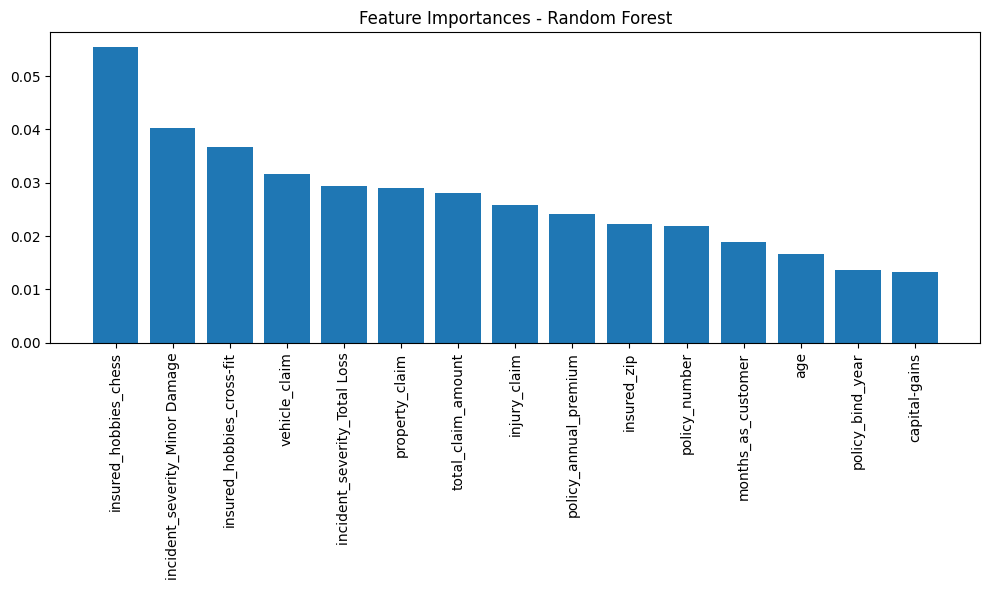

In [141]:
import matplotlib.pyplot as plt
import numpy as np

rf_model = best_model.named_steps["classifier"]
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols)
num_features = X_train.drop(columns=cat_cols).columns
all_features = list(ohe_features) + list(num_features)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [all_features[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


### B: XGBoost

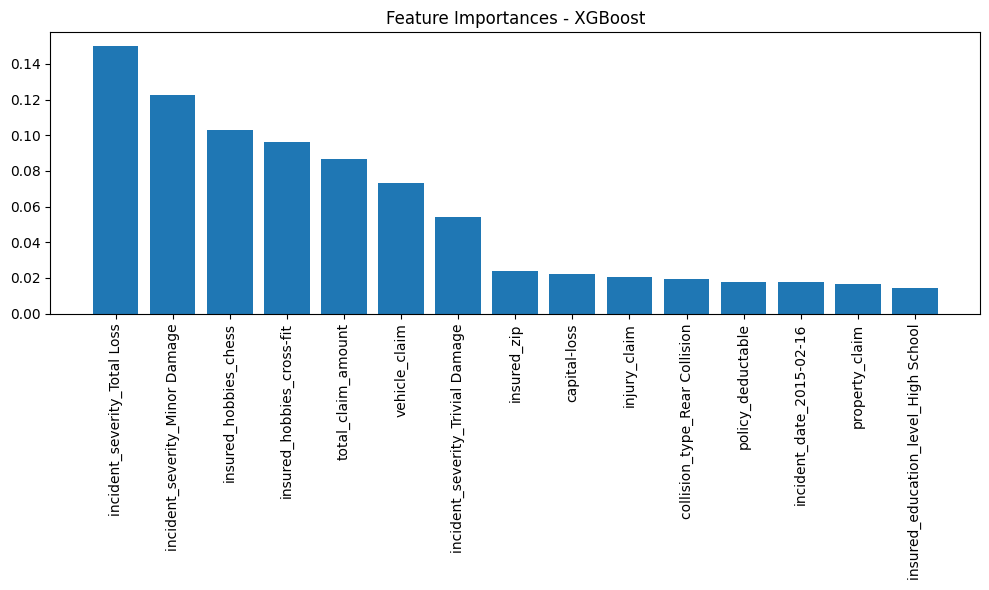

In [143]:
xgb_model = xgb_grid.best_estimator_.named_steps["classifier"]

importances = xgb_model.feature_importances_
ohe = xgb_grid.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols)
num_features = X_train.drop(columns=cat_cols).columns
all_features = list(ohe_features) + list(num_features)

import numpy as np
import matplotlib.pyplot as plt

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [all_features[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


### 3: LightGBM

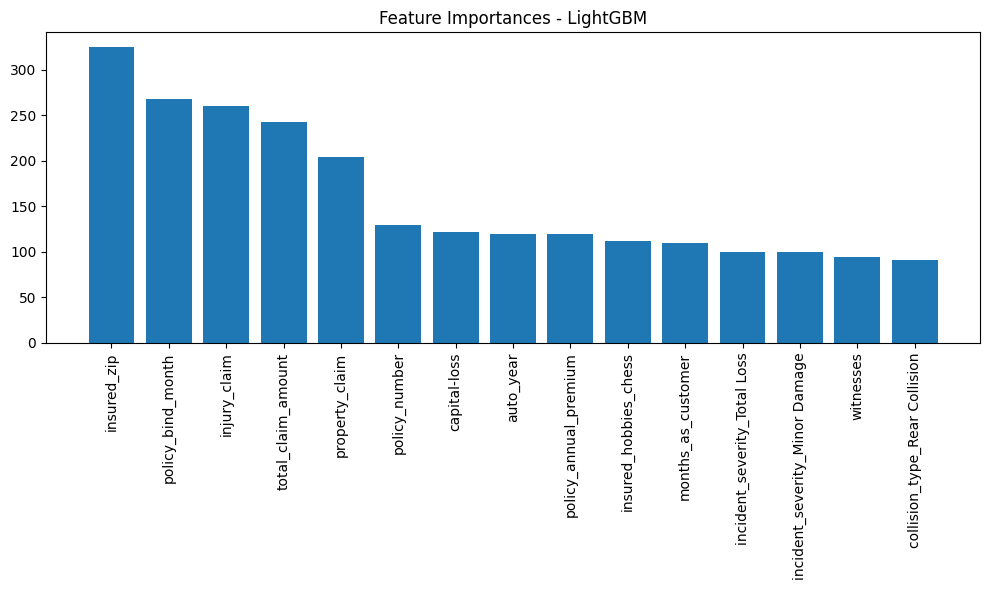

In [144]:
import matplotlib.pyplot as plt
import numpy as np

lgbm_model = lgbm_random_search.best_estimator_.named_steps["classifier"]

ohe = lgbm_random_search.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols)
num_features = X_train.drop(columns=cat_cols).columns
all_features = list(ohe_features) + list(num_features)

importances = lgbm_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - LightGBM")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [all_features[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


## 2: Partial Dependence Plots

### 1: Random Forest

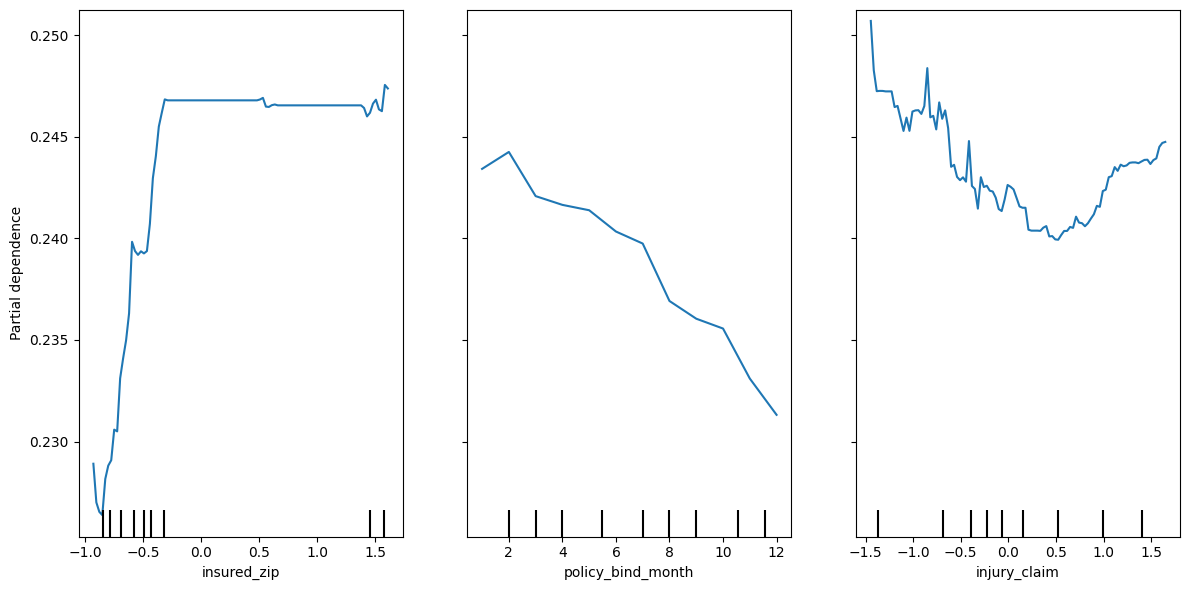

In [147]:
from sklearn.inspection import PartialDependenceDisplay

top_3_features = [all_features[i] for i in indices[:3]]

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(best_model, X_val, top_3_features, ax=ax)
plt.tight_layout()
plt.show()


### 2: LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

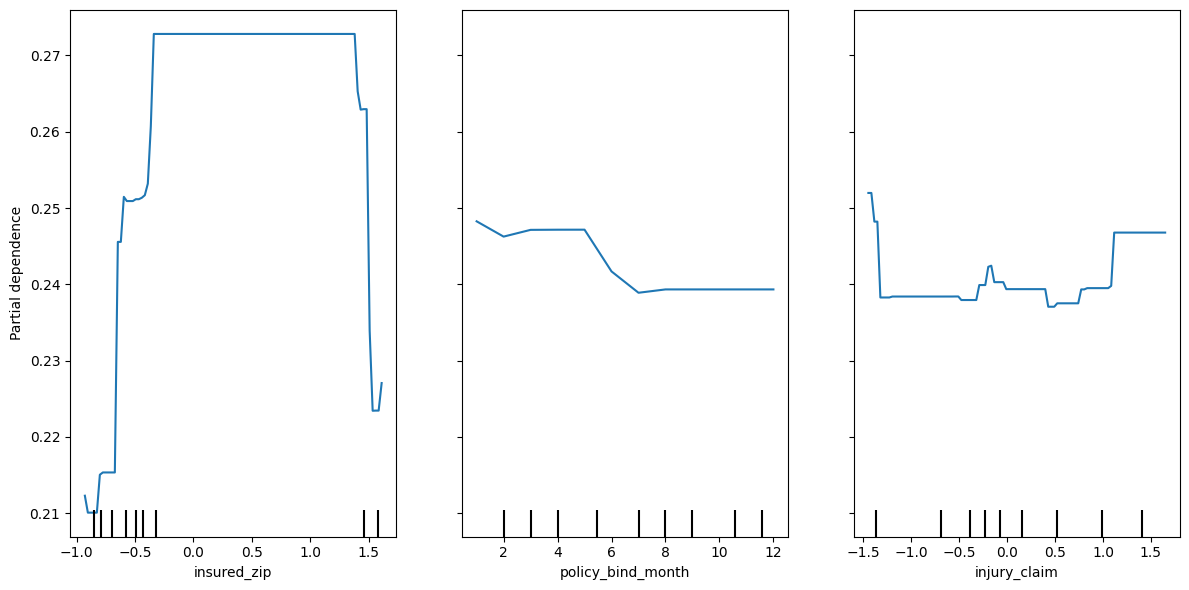

In [148]:
from sklearn.inspection import PartialDependenceDisplay

top_features = [all_features[i] for i in indices[:3]]  # top 3 features

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(lgbm_random_search.best_estimator_, X_val, top_features, ax=ax)
plt.tight_layout()
plt.show()


### 3: XGBoost

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

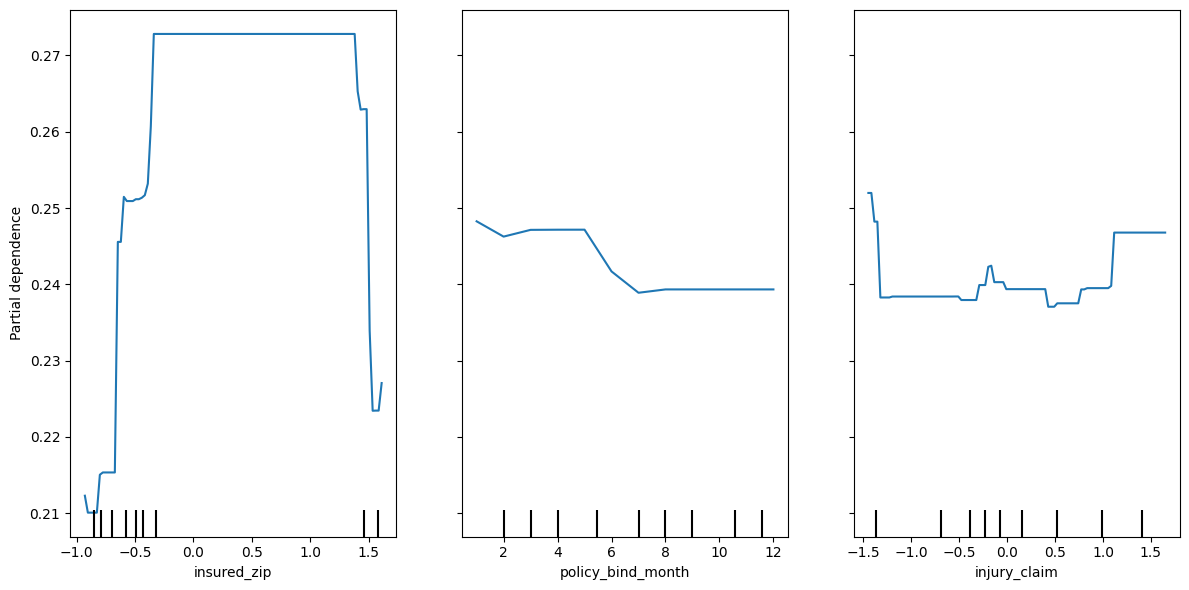

In [145]:
from sklearn.inspection import PartialDependenceDisplay

top_features = [all_features[i] for i in indices[:3]]

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(lgbm_random_search.best_estimator_, X_val, top_features, ax=ax)
plt.tight_layout()
plt.show()


----

----

# **My trained model using random samples from the dataset**

In [153]:
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

df_clean = pd.read_csv("cleaned_fraud_data.csv")

df_clean = df_clean.select_dtypes(include=['number', 'bool'])

X = df_clean.drop("fraud_reported", axis=1)
y = df_clean["fraud_reported"]

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X, y)

random_samples = df_clean.sample(n=25, random_state=42)
X_random = random_samples.drop("fraud_reported", axis=1)
y_actual = random_samples["fraud_reported"]

y_pred = model.predict(X_random)

results = pd.DataFrame({
    "Predicted": y_pred,
    "Actual": y_actual.values
})
print("Random Sample Predictions:\n")
print(results)

joblib.dump(model, "best_model.pkl")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Sample Predictions:

    Predicted  Actual
0           0       0
1           0       0
2           0       0
3           0       0
4           0       0
5           0       0
6           0       0
7           1       1
8           0       0
9           0       0
10          0       0
11          0       0
12          0       0
13          1       1
14          1       1
15          0       0
16          0       0
17          1       1
18          1       1
19          1       1
20          0       0
21          0       0
22          0       0
23          0       0
24          0       0


['best_model.pkl']

In [154]:
import joblib
from google.colab import files


files.download("best_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>